# Importing the libraries

In [23]:
#Make sure that you have all the librarys installed

import numpy as np
import pandas as pd
import datetime
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.optimize as opt
import warnings

# Reading the data

In [24]:
urlConfirmed='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
COVID19Series = pd.read_csv(urlConfirmed)

urlDeaths='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
COVID19Deaths= pd.read_csv(urlDeaths)

In [25]:
FirstUpdate = COVID19Series.columns[4]
LastUpdate = COVID19Series.columns[-1]

print('First update:',FirstUpdate)
print('Last update:',LastUpdate)

First update: 1/22/20
Last update: 4/27/20


## Functions

In [26]:
#Function to display all the data table
def displayData(df,displayBool):
    if displayBool==True:
        #Setting to display all contents
        pd.set_option('display.max_rows', len(df))
        pd.set_option('display.max_columns', len(df))
        #display the content
        display(HTML(df.to_html()))

In [27]:
#Create a list of countries with highest number of the value of dataFrame
def HighestCountries(df,numberOfcontries):
    
    #Trasnpose a DataFrame to use the nlargest method in LastUpdate column and traspose again 
    return df.T.nlargest(numberOfcontries,LastUpdate).T

In [110]:
#A function to create a DataFrame with how many days passed since the first numberOfCases
def perDay(df, registeredCases):
    
    #create a empty list to append
    y_array = []
    #if type(df)==pd.core.frame.DataFrame:
    for country in df.columns:

        #creates an array with values greater than numberOfCases
        temp = np.array(df[country].T)
        y_filter = np.where(temp > registeredCases) 
        y = list(temp[y_filter])

        #measures how many elements must be fill in
        fillNaN = len(df.index)-len(y)

        #fill the last values arrays with NaN
        y.extend(np.full(fillNaN, np.nan))
        y_array.append(y)

    return pd.DataFrame(y_array, index=df.columns).T
   

In [29]:
#A function to create a horizontal bar plot with an array of countries names
def barPlot(CountryList,title):

    numberOfCases = df[CountryList].iloc[-1]
    numberOfDeaths = dfDeaths[CountryList].iloc[-1]
    newCases =  numberOfCases - df[CountryList].iloc[-2]
    newDeaths = numberOfDeaths - dfDeaths[CountryList].iloc[-2]
    rateDeaths = (numberOfDeaths/numberOfCases)
    
    #mesures the how many days passed since the first death
    days = len(perDay(dfDeaths[CountryList],0).index)- perDay(
        dfDeaths[CountryList],0).isna().sum()

    fig, ax = plt.subplots(1, 1, figsize=(7, 3))
    ax.barh(CountryList,numberOfCases, color='C2')
    ax.barh(CountryList,numberOfCases - newCases,color='C0')
    ax.barh(CountryList,numberOfDeaths,color='C1')
    ax.barh(CountryList,numberOfDeaths - newDeaths,color='C3')
    ax.legend(labels=['New Cases','Confirmed cases','New Deaths','Deaths'])
    ax.set_xlabel('Number of Cases until the day %s' %LastUpdate)
    ax.set_title(title)
    


    #Show the percentage of the deaths after the bars
    for i, (value1,value2,value3, name) in enumerate(zip(newCases,numberOfDeaths,newDeaths,
                                                         df[CountryList].columns)):
        ax.text(numberOfCases[i], i, '%.0f  ' % (newCases[i]), ha='left', color='C2')
        ax.text(numberOfDeaths[i], i, '''%.0f''' % (newDeaths[i]), ha='left', color='C1')

        
    #Zip to print and flip to displays data in the same order as the graph
    printData=zip(np.flip(CountryList),np.flip(days),np.flip(numberOfCases),
                  np.flip(numberOfDeaths),np.flip(rateDeaths*100),np.flip(newCases),np.flip(newDeaths))

    print("Country: Days since the first death; Total deaths; percentage of deaths; confimed Cases")
    for country, days, numberOfCases,numberOfDeaths,rateDeaths,newCases,newDeaths in printData: 
        print ("%s: %0.f; %.0f (%.0f new); %.2f%%; %.0f (%.0f new); " %(country,days,numberOfDeaths,
                                                        newDeaths,rateDeaths,numberOfCases,newCases))

In [30]:
#Define a exponetial function
def exponential_func(x, a, b,c):
    return a*np.exp(b*x) + c

In [78]:
#Define a logistic function
def logistic_func(x, L, x0, k, A):
    return L/(1+np.exp(-k*(x-x0)))+A

In [189]:
#Create a DataFrame with a fit function
def fit(df,L,x0,k,A=0,registeredCases=0):

    days = len(df.index)- perDay(
        df,registeredCases).isna().sum()
    
    x_array = []
    y_array = []
    label_array=[]
    for country in df.columns:
        y=df.T.loc[country]
        
        y=y[:days[country]]
        x=range(len(y))
        
        
        #fit a function with the data
           
        #Using a exponential
        #popt, pcov = opt.curve_fit(exponential_func, x, y, p0=(1, 1, 0), bounds=(0,[np.inf, 2, np.inf]))
        #label=['%s $e^{%.2ft}$' % (country,popt[1])]
        
        #Using a logistic Function
        popt, pcov = opt.curve_fit(logistic_func, x, y, p0=(L, x0, k, A))# bounds=(0,[np.inf, 2, np.inf]))
        label=[r'%s $\frac{%.0f}{1+e^{-%.2f(t-%0.f)}}$' % (country,popt[0],popt[2],popt[1])]
        
        label_array.extend(label)
        
        #Create a data fit
        
        #using exponential
        #yy = exponential_func(x, *popt)
        
        #using a logistic function
        yy = logistic_func(x, *popt)
        yy = list(yy)
        
        #fill the last values arrays with NaN
        fillNaN = len(df.index)-len(y)
        yy.extend(np.full(fillNaN, np.nan))
        y_array.append(yy)
    
    return pd.DataFrame(y_array, index=label_array).T

# Organizing the data

In [33]:
#Display raw data
displayData(COVID19Series,False)

#Group by countries
dfGroup = COVID19Series.groupby('Country/Region')

#Transpose the data and sum all the regions of the country
dfT = dfGroup.sum().T
#Removing the latitude and longitude 
df = dfT.loc[FirstUpdate:]

#Displays all confirmed cases of COVID-19 by days and countries
displayData(df,False)

#Group by countries
dfDeathsGroup = COVID19Deaths.groupby('Country/Region')

#Transpose the data and sum all the regions of the country
dfDeathsT= dfDeathsGroup.sum().T

#Removing the latitude and longitude 
dfDeaths = dfDeathsT.loc[FirstUpdate:]

#Displays the entire COVID-19 deaths table by days and countries
displayData(dfDeaths,False)

# Plot the data of the confirmed cases

Country: Days since the first death; Total deaths; percentage of deaths; confimed Cases
China: 97; 4637 (0 new); 5.53%; 83918 (6 new); 
Russia: 40; 794 (47 new); 0.91%; 87147 (6198 new); 
Iran: 69; 5806 (96 new); 6.35%; 91472 (991 new); 
Turkey: 42; 2900 (95 new); 2.58%; 112261 (2131 new); 
United Kingdom: 54; 21157 (363 new); 13.36%; 158348 (4311 new); 
Germany: 50; 6126 (150 new); 3.86%; 158758 (988 new); 
France: 73; 23327 (437 new); 14.06%; 165963 (3743 new); 
Italy: 67; 26977 (333 new); 13.53%; 199414 (1739 new); 
Spain: 56; 23521 (331 new); 10.25%; 229422 (2793 new); 
US: 59; 56259 (1378 new); 5.69%; 988197 (22412 new); 


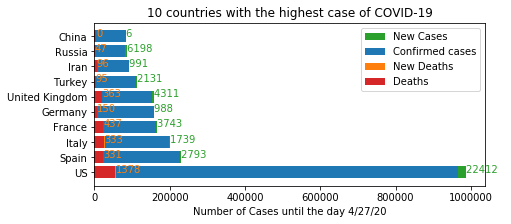

In [34]:
#plot a horizontal bar with the 10 countries with highest cases
#barPlot(CountryList,registeredCases,title)
barPlot(HighestCountries(df,numberOfcontries=10).columns,'10 countries with the highest case of COVID-19')

Country: Days since the first death; Total deaths; percentage of deaths; confimed Cases
Brazil: 42; 4603 (317 new); 6.82%; 67446 (4346 new); 
China: 97; 4637 (0 new); 5.53%; 83918 (6 new); 
Iran: 69; 5806 (96 new); 6.35%; 91472 (991 new); 
Germany: 50; 6126 (150 new); 3.86%; 158758 (988 new); 
Belgium: 48; 7207 (113 new); 15.44%; 46687 (553 new); 
United Kingdom: 54; 21157 (363 new); 13.36%; 158348 (4311 new); 
France: 73; 23327 (437 new); 14.06%; 165963 (3743 new); 
Spain: 56; 23521 (331 new); 10.25%; 229422 (2793 new); 
Italy: 67; 26977 (333 new); 13.53%; 199414 (1739 new); 
US: 59; 56259 (1378 new); 5.69%; 988197 (22412 new); 


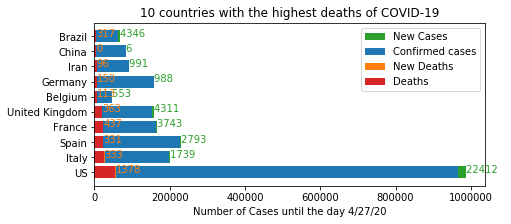

In [35]:
#plot a horizontal bar with the 10 countries with highest deaths
barPlot(HighestCountries(dfDeaths,numberOfcontries=10).columns,'10 countries with the highest deaths of COVID-19')

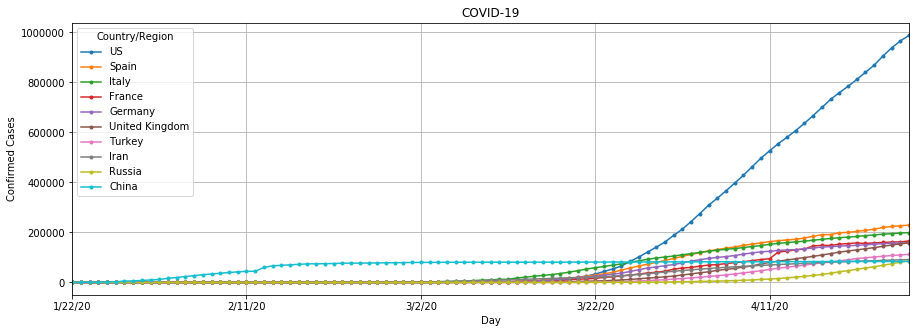

In [36]:
HighestCountries(df,10).plot(marker='.',figsize=(15,5))
plt.title('COVID-19')
plt.xlabel('Day')
plt.ylabel('Confirmed Cases')
plt.grid()
#plt.savefig('ConfirmedCasesInCalendar.png', dpi=300)

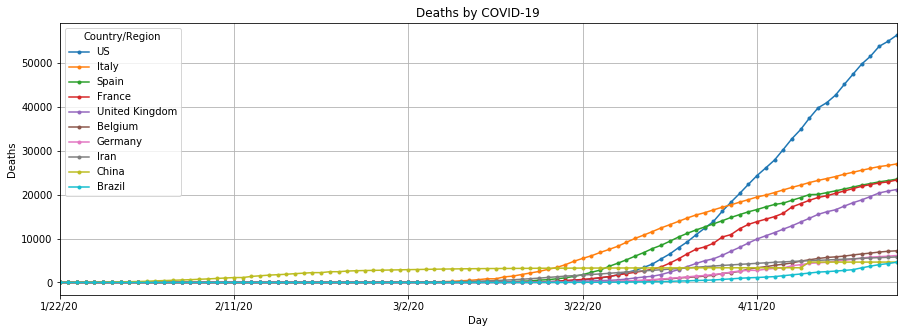

In [37]:
HighestCountries(dfDeaths,10).plot(marker='.',figsize=(15,5))
plt.title('Deaths by COVID-19')
plt.xlabel('Day')
plt.ylabel('Deaths')
plt.grid()
#plt.savefig('DeathsInCalendar.png', dpi=300)

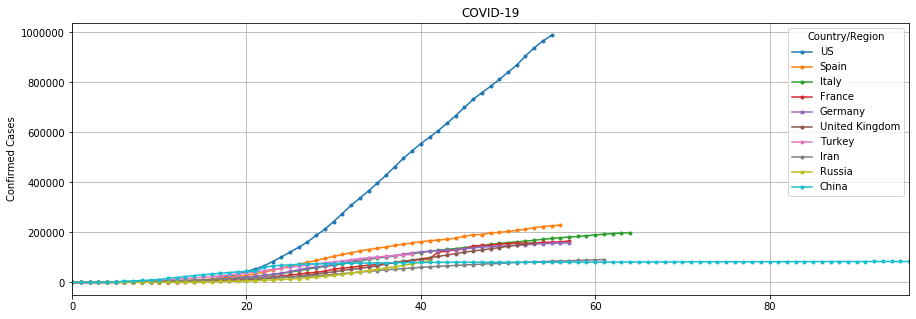

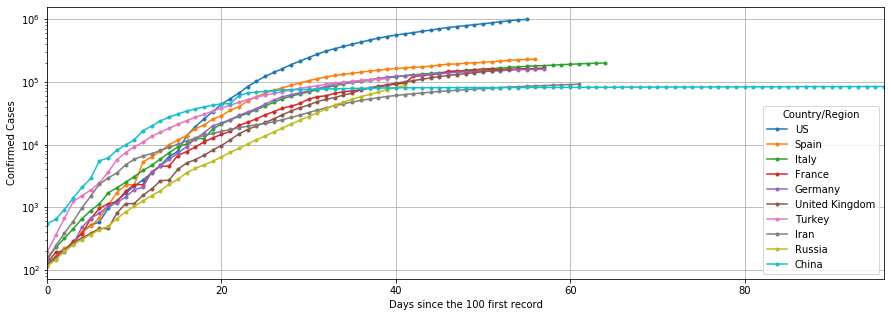

In [38]:
D=100
perDay(HighestCountries(df,10),D).plot(marker='.',figsize=(15,5))
plt.title('COVID-19')
plt.ylabel('Confirmed Cases')
plt.grid()
perDay(HighestCountries(df,10),D).plot(logy=True, marker='.',figsize=(15,5))
plt.ylabel('Confirmed Cases')
if D==0:
    plt.xlabel('Days since the first record'),
else:
    plt.xlabel('Days since the %d first record' % D)
plt.grid()
#plt.savefig('CasesVSDays.png', dpi=300)

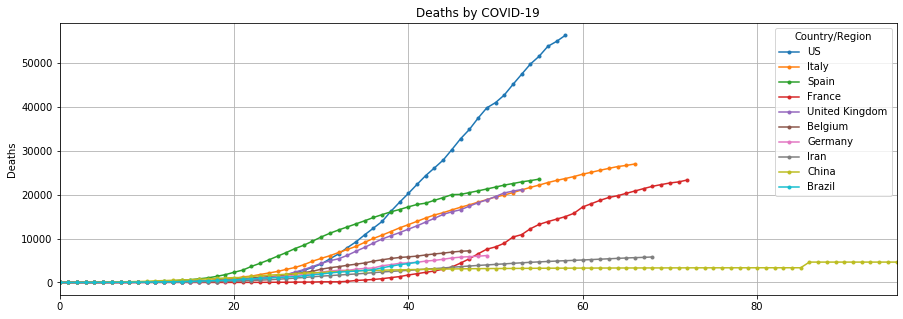

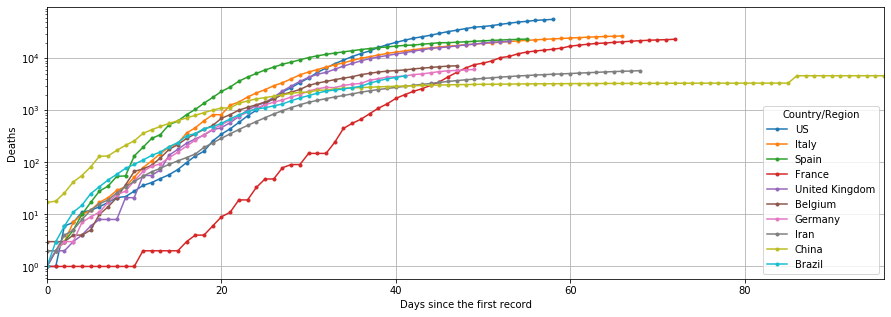

In [39]:
D=0
perDay(HighestCountries(dfDeaths,10),D).plot(marker='.',figsize=(15,5))
plt.title('Deaths by COVID-19')
plt.ylabel('Deaths')
plt.grid()
perDay(HighestCountries(dfDeaths,10),D).plot(logy=True, marker='.',figsize=(15,5))
plt.ylabel('Deaths')
if D==0:
    plt.xlabel('Days since the first record'),
else:
    plt.xlabel('Days since the %d first record' % D)
plt.grid()
#plt.savefig('DeathsVSDays.png', dpi=300)

## Problems with discontinuity in China

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

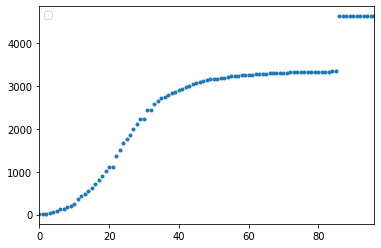

In [196]:
D=0

L=25000
x0=40
k=0.1
data = perDay(dfDeaths['China'].to_frame(),D)
ax = data.plot(style='.')
ax.legend('')

fitData = fit(data,L,x0,k)
fitData.plot(ax=ax, figsize=(15,8))

plt.title('10 countries with the highest deaths by COVID-19')
plt.ylabel('Deaths')
plt.legend(fitData.columns, prop={'size': 15}, markerscale=2)
if D==0:
    plt.xlabel('t days since the first record'),
else:
    plt.xlabel('t days since the %d first record' % D)

plt.grid()
plt.savefig('FitDeathsVSDays.png', dpi=300)

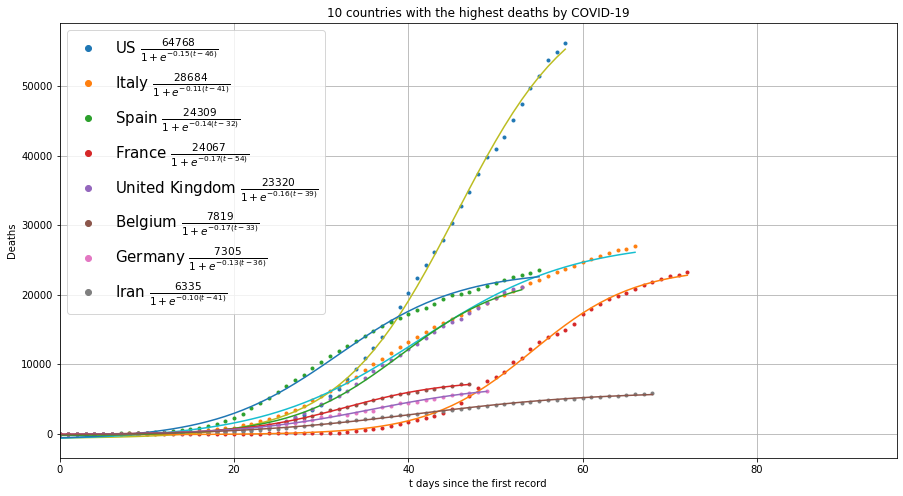

In [198]:
D=0

L=25000
x0=40
k=0.1
data = perDay(HighestCountries(dfDeaths,8),D)
ax = data.plot(style='.')
ax.legend('')

fitData = fit(data,L,x0,k)
fitData.plot(ax=ax, figsize=(15,8))

plt.title('10 countries with the highest deaths by COVID-19')
plt.ylabel('Deaths')
plt.legend(fitData.columns, prop={'size': 15}, markerscale=2)
if D==0:
    plt.xlabel('t days since the first record'),
else:
    plt.xlabel('t days since the %d first record' % D)

plt.grid()
plt.savefig('FitDeathsVSDays.png', dpi=300)

